In [1]:
# Load scenarios

%matplotlib inline

from collections import Counter, defaultdict
import glob
import gzip
import json
import math
from operator import itemgetter
import os
from pathlib import Path

from IPython.display import display, Markdown
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from pygtrie import StringTrie
import seaborn as sns

CALIBRATION_RESULTS = Path("./benchmark-variance")

In [2]:
data = defaultdict(list)

for filepath in glob.iglob(os.path.join(CALIBRATION_RESULTS, "*.json")):
    total = 0
    with open(filepath) as f:
        measurements = json.load(f)
    for key, value in measurements.items():
        data["scenario"].append(key)
        data["timeMs"].append(value["timeMs"])
        total += value["timeMs"]
    data["scenario"].append("total")
    data["timeMs"].append(total)

df = pd.DataFrame(data)
df.describe()

,timeMs
count,2.100000e+02
mean,1.003106e+06
std,1.346306e+06
min,3.240589e+03
25%,1.811868e+04
50%,7.154021e+04
75%,2.188296e+06
max,3.730737e+06


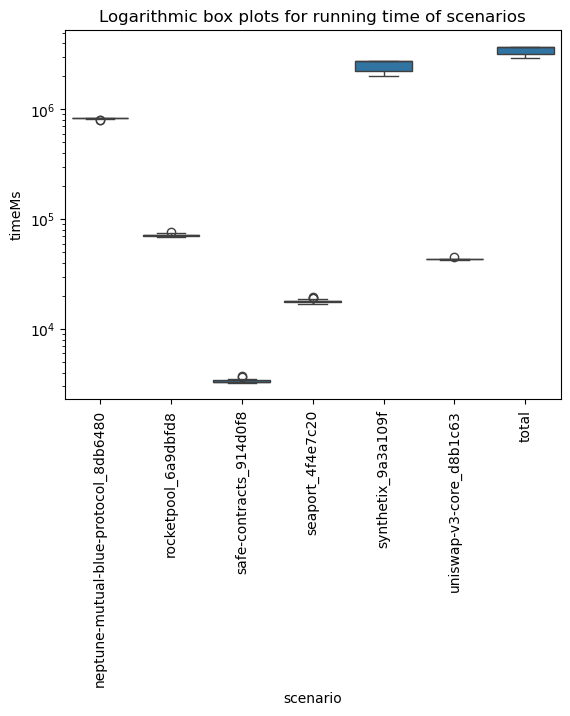

In [3]:
ax = sns.boxplot(x="scenario", y="timeMs", data=df)
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Logarithmic box plots for running time of scenarios")

In [4]:
df.groupby("scenario")["timeMs"].max() / df.groupby("scenario")["timeMs"].min()

scenario
neptune-mutual-blue-protocol_8db6480    1.044447
rocketpool_6a9dbfd8                     1.110794
safe-contracts_914d0f8                  1.141530
seaport_4f4e7c20                        1.148250
synthetix_9a3a109f                      1.378203
total                                   1.257722
uniswap-v3-core_d8b1c63                 1.044686
Name: timeMs, dtype: float64